In [1]:
import itertools
import json
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import set_config
set_config(display='diagram')

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict, GridSearchCV, train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import MinMaxScaler

In [2]:
train = pd.read_csv('../data/final/train.csv')

In [3]:
train.head()

,review_text,lemma_sent,subjectivity,negative,neutral,positive,t_n_tokens,t_polarity,t_compound,w2v_feat,target
0,I got the cream color and absolutely love the ...,get cream color absolutely love style color sw...,0.530952,0.064,0.679,0.257,0.625000,0.595238,0.943500,[ 0.05478151 0.01727459 -0.00400193 0.122406...,0
1,If your hips are bigger than a size 6 us you c...,hips bigger size us cannot fully close robe mo...,0.587302,0.099,0.706,0.194,0.625000,0.521429,0.820884,[-1.29353256e-02 1.37898176e-02 3.28546384e-...,0
2,"This has great drape, length, the pattern is s...",great drape length pattern super versatile sol...,0.738889,0.057,0.568,0.376,0.446429,0.747917,0.948617,[ 0.04326035 0.04995556 -0.06287014 0.068289...,0
3,When i read all these positive reviews i did n...,read positive review hesitate want good basics...,0.395804,0.027,0.495,0.478,0.910714,0.660664,0.994417,[-9.90957397e-03 4.72112603e-02 -1.73662261e-...,1
4,I love this skirt. the material is soft and be...,love skirt material soft beautiful love wear b...,0.597959,0.072,0.599,0.329,0.589286,0.597789,0.955027,[-1.27153633e-02 1.51035811e-02 -2.00997431e-...,0


In [4]:
X = train.drop(labels=['target', 'w2v_feat', 'review_text'], axis=1)
y = train['target']

In [5]:
NUMERICALS = ['subjectivity', 'negative', 'neutral', 'positive', 't_n_tokens', 't_polarity', 't_compound']

numeric_preproc = ColumnTransformer([('scaler', MinMaxScaler(), NUMERICALS)])
tfidf_preproc = ColumnTransformer([('vectorizer', TfidfVectorizer(), 'lemma_sent')])

feature_combiner = FeatureUnion([('scaler', numeric_preproc), ('vectorizer', tfidf_preproc)])
classifier = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [6]:
param_grid = {
    'preprocessor__vectorizer__vectorizer__max_features': [1000, 2500, 5000, 7500],
    'preprocessor__vectorizer__vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'preprocessor__vectorizer__vectorizer__max_df': [.25, .5, .75, 1.0],
}

pipe = Pipeline([
    ('preprocessor', feature_combiner),
    ('classifier', classifier)
])

gs_model = GridSearchCV(
    pipe, 
    cv=5, 
    n_jobs=1, 
    param_grid=param_grid, 
    scoring='recall', 
    error_score='raise', 
    verbose=2
)

In [7]:
gs_model.fit(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END preprocessor__vectorizer__vectorizer__max_df=0.25, preprocessor__vectorizer__vectorizer__max_features=1000, preprocessor__vectorizer__vectorizer__ngram_range=(1, 1); total time=   0.5s
[CV] END preprocessor__vectorizer__vectorizer__max_df=0.25, preprocessor__vectorizer__vectorizer__max_features=1000, preprocessor__vectorizer__vectorizer__ngram_range=(1, 1); total time=   0.5s
[CV] END preprocessor__vectorizer__vectorizer__max_df=0.25, preprocessor__vectorizer__vectorizer__max_features=1000, preprocessor__vectorizer__vectorizer__ngram_range=(1, 1); total time=   0.5s
[CV] END preprocessor__vectorizer__vectorizer__max_df=0.25, preprocessor__vectorizer__vectorizer__max_features=1000, preprocessor__vectorizer__vectorizer__ngram_range=(1, 1); total time=   0.5s
[CV] END preprocessor__vectorizer__vectorizer__max_df=0.25, preprocessor__vectorizer__vectorizer__max_features=1000, preprocessor__vectorizer__vectorizer__ngram_r

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        FeatureUnion(transformer_list=[('scaler',
                                                                        ColumnTransformer(transformers=[('scaler',
                                                                                                         MinMaxScaler(),
                                                                                                         ['subjectivity',
                                                                                                          'negative',
                                                                                                          'neutral',
                                                                                                          'positive',
                                                                                                          't_n_tokens',
                                                                                                          't_polarity',
                                                                                                          't_compound'])])),
                                                                       ('vectorizer',
                                                                        ColumnTransformer(transformers=[('vectorizer',
                                                                                                         TfidfVectorizer(),
                                                                                                         'l...
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           random_state=42))]),
             n_jobs=1,
             param_grid={'preprocessor__vectorizer__vectorizer__max_df': [0.25,
                                                                          0.5,
                                                                          0.75,
                                                                          1.0],
                         'preprocessor__vectorizer__vectorizer__max_features': [1000,
                                                                                2500,
                                                                                5000,
                                                                                7500],
                         'preprocessor__vectorizer__vectorizer__ngram_range': [(1,
                                                                                1),
                                                                               (1,
                                                                                2),
                                                                               (1,
                                                                                3)]},
             scoring='recall', verbose=2)

In [8]:
print(gs_model.best_score_)

0.8314738685593144


In [9]:
print(gs_model.best_params_)

{'preprocessor__vectorizer__vectorizer__max_df': 0.5, 'preprocessor__vectorizer__vectorizer__max_features': 1000, 'preprocessor__vectorizer__vectorizer__ngram_range': (1, 1)}


In [10]:
print(gs_model.best_estimator_)

Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('scaler',
                                                 ColumnTransformer(transformers=[('scaler',
                                                                                  MinMaxScaler(),
                                                                                  ['subjectivity',
                                                                                   'negative',
                                                                                   'neutral',
                                                                                   'positive',
                                                                                   't_n_tokens',
                                                                                   't_polarity',
                                                                                   't_compound'])])),
                                       

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 fontsize=12,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

Classification Report : Logistic Regression (TFIDF)

-------------------------------------
                 precision    recall  f1-score   support

    recommended       0.96      0.86      0.90     12994
not-recommended       0.56      0.83      0.67      2854

       accuracy                           0.85     15848
      macro avg       0.76      0.84      0.79     15848
   weighted avg       0.89      0.85      0.86     15848

Confusion Matrix : Logistic Regression (TFIDF)

-------------------------------------


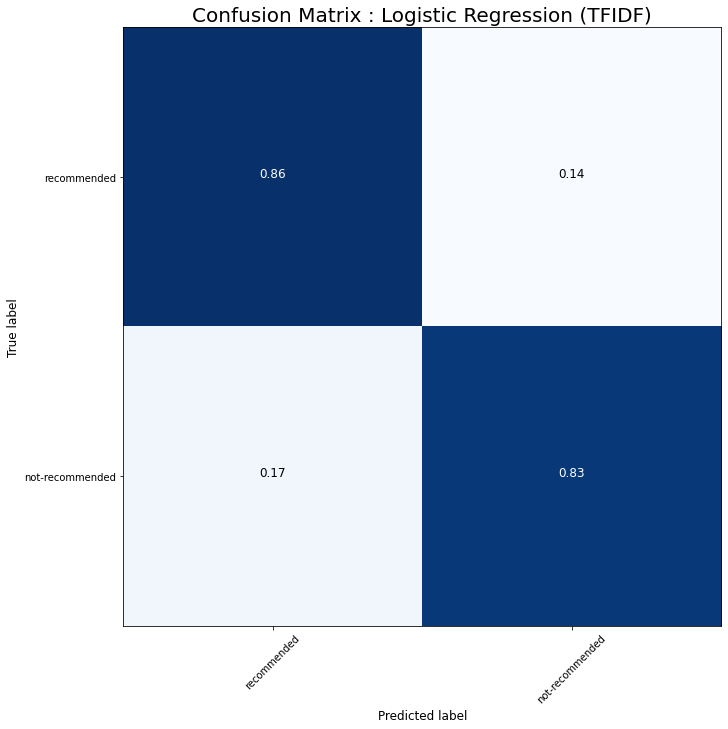

In [12]:
# print classification reports
TARGETS = ['recommended', 'not-recommended']

y_pred = cross_val_predict(gs_model.best_estimator_, X, y)
print(f'Classification Report : Logistic Regression (TFIDF)\n')
print('-------------------------------------')
print(classification_report(y, y_pred, target_names=TARGETS))

# print confusion matrices
print(f'Confusion Matrix : Logistic Regression (TFIDF)\n')
print('-------------------------------------')
plot_confusion_matrix(confusion_matrix(y, y_pred), classes=['recommended','not-recommended'], normalize=True, title=f'Confusion Matrix : Logistic Regression (TFIDF)')
plt.grid(False)
plt.savefig(f'../assets/tfidf_{"Logistic Regression (TFIDF)".lower()}.png')
plt.show()

In [13]:
joblib.dump(gs_model.best_estimator_, '../models/logistic-regression-tuned.joblib')

['../models/logistic-regression-tuned.joblib']